In [82]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
from IPython.display import display, Math

def print_matrix(array):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

In [87]:
def create_QUBO_MATRIX(number_of_tracks=4, 
                       number_of_noise_triplets=4,
                       max_number_conflicts=5,
                       max_connection_numbers_matches=1,
                       max_connection_numbers_fakes=1):
    
    QUBO_MATRIX = np.zeros((2 * number_of_tracks + number_of_noise_triplets, 
                            2 * number_of_tracks + number_of_noise_triplets))

    # quality values of matched triplets
    for i in range(0, 2 * number_of_tracks):
        QUBO_MATRIX[i, i] = np.around(np.random.normal(-0.3, 0.1), 4)

    # connections of triplets - conflicts are modelled later    
    for i in range(0, 2 * number_of_tracks, 2):

        # correct connection = very good connection value
        QUBO_MATRIX[i, i + 1] = np.around(np.random.normal(-0.98, 0.005), 4)

        # randomising connection number
        num_additional_connections = int(np.random.uniform(0, max_connection_numbers_matches))
        for i in range(num_additional_connections):

            # not overwriting quality or existing value
            pass_check = False
            while not pass_check:
                connection = np.random.randint(0, 2 * number_of_tracks + number_of_noise_triplets)
                if connection not in [i, i + 1]:
                    pass_check = True
            # additional connection rated lower
            QUBO_MATRIX[i, connection] = np.around(np.random.normal(-0.95, 0.01), 4)

            # need to add a conflict to the real partner, otherwise both will be chosen
            QUBO_MATRIX[i + 1, connection] == 1

    # connections and conflicts fake triplets        
    for i in range(2 * number_of_tracks, 2 * number_of_tracks + number_of_noise_triplets):
        interactions = set() # no double counting

        # worse connection for false triplets
        QUBO_MATRIX[i, i] = np.around(np.random.normal(0.3, 0.1), 4)

        # random combinatorial conections
        num_combinatorial_connections = int(np.random.uniform(0, max_connection_numbers_fakes + 1))
        for j in range(num_combinatorial_connections):

            # not overwriting quality or existing value
            pass_check = False
            while not pass_check:
                connection = np.random.randint(0, 2 * number_of_tracks + number_of_noise_triplets)
                if connection not in interactions and connection != i:
                    pass_check = True
            if connection > i :
                QUBO_MATRIX[i, connection] = np.around(np.random.normal(-0.95, 0.01), 4)
                if connection % 2 == 0:
                    if connection + 1 != i:
                        QUBO_MATRIX[i, connection + 1] = 1
                else:
                    if connection - 1 != i :
                        QUBO_MATRIX[i, connection - 1] = 1
            else:
                QUBO_MATRIX[connection, i] = np.around(np.random.normal(-0.95, 0.01), 4) 
                if connection % 2 == 0:
                    if connection + 1 != i:
                        QUBO_MATRIX[connection + 1, i] = 1
                else:
                    if connection - 1 != i:
                        QUBO_MATRIX[connection - 1, i] = 1
                interactions.add(connection)    

        num_conflicts = int(np.random.uniform(2, max_number_conflicts + 1))
        for k in range(num_conflicts):
            pass_check = False
            while not pass_check:
                conflict = np.random.randint(0, 2 * number_of_tracks + number_of_noise_triplets)
                if conflict not in interactions and conflict != i:
                    pass_check = True
            if conflict > i:
                QUBO_MATRIX[i, conflict] = 1
            else:
                QUBO_MATRIX[conflict, i] = 1
            interactions.add(conflict)    

    for i in range(len(QUBO_MATRIX)):
        for j in range(len(QUBO_MATRIX)):
            if i < j:
                QUBO_MATRIX[j, i] = QUBO_MATRIX[i, j]
    return QUBO_MATRIX

def correct_initial_solution(number_of_tracks=4, 
                             number_of_noise_triplets=4):
    return [1 for i in range(2 * number_of_tracks)] + [0 for i in range(number_of_noise_triplets)]

In [88]:
def get_lowest_energy_solution_by_brute_force(QUBO_MATRIX):
    best_result = 0
    best_vector = None
    for i in range(2**(len(QUBO_MATRIX))):
        bin_string = bin(i).replace("0b", "").zfill(len(QUBO_MATRIX))
        vector = [int(c) for c in bin_string]
        cost = np.dot(np.dot(vector, QUBO_MATRIX), vector)
        if cost < best_result:
            best_result = cost
            best_vector = vector

    return best_vector

In [89]:
iterations = 1

check_solution = []
number_wrong_assignments = []

for i in range(iterations):
    q_m = create_QUBO_MATRIX()
    correct_solution = correct_initial_solution()
    brute_force = get_lowest_energy_solution_by_brute_force(q_m)
    if brute_force == correct_solution:
        check_solution.append(1)
        number_wrong_assignments.append(0)
    else:
        check_solution.append(0)
        number_wrong_assignments.append(sum([abs(i -j) for i,j in zip(brute_force, correct_solution)]))
    print(correct_solution)
    print(brute_force)
    
print(f"In {np.around(100 * sum(check_solution) / iterations, 4)} % the correct solution should be found")  


[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
In 100.0 % the correct solution should be found


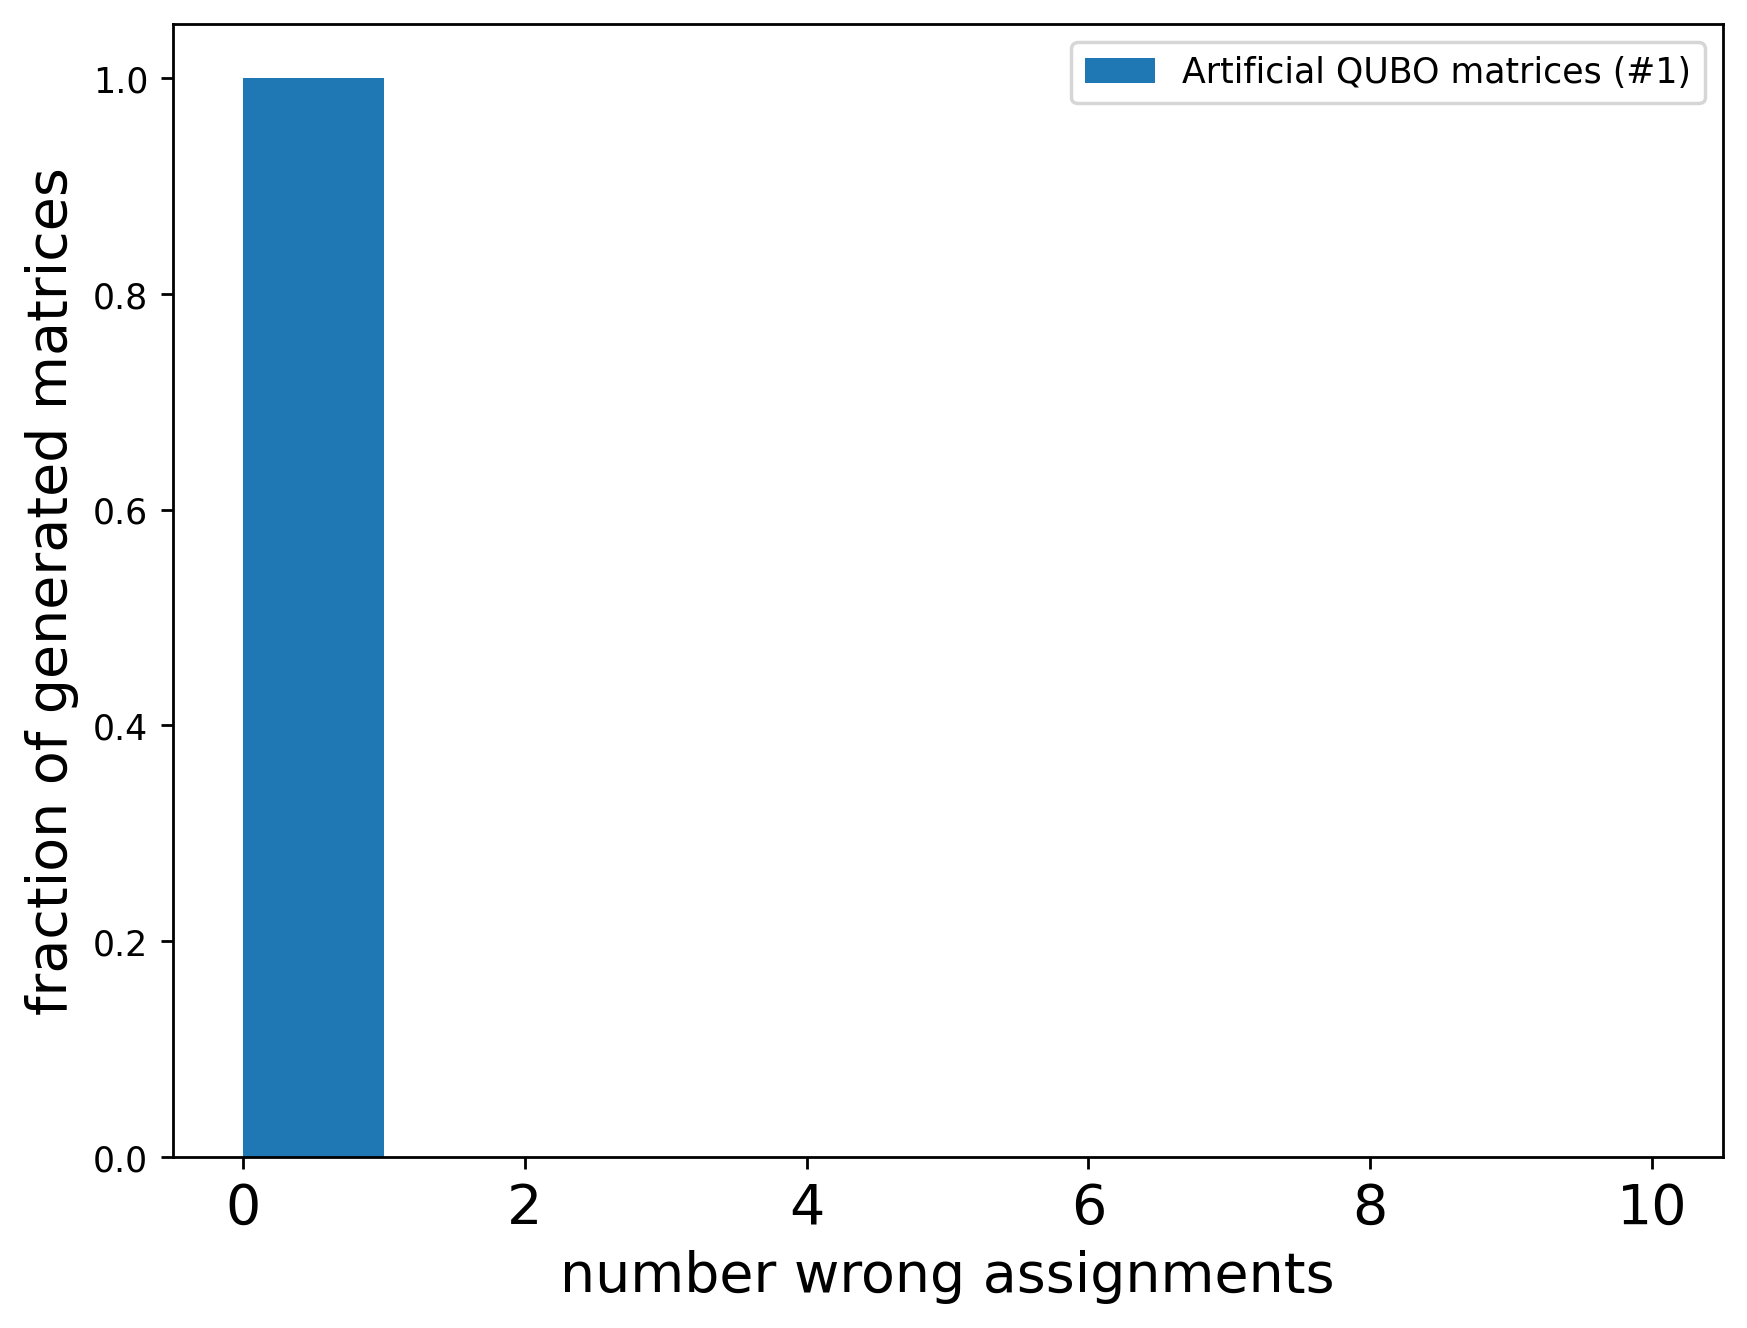

In [90]:
plt.figure(figsize=(8,6), dpi=250)
plt.hist(number_wrong_assignments, range=(0, 10), bins=10, label=f"Artificial QUBO matrices (#{iterations})",
        density=True)
plt.xlabel("number wrong assignments", fontsize=16)
plt.ylabel("fraction of generated matrices", fontsize=16)
plt.legend(loc="best")
plt.xticks(fontsize=16)
plt.show()

In [91]:
print_matrix(create_QUBO_MATRIX())

<IPython.core.display.Math object>